In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from src.env.DunderBotEnv import DunderBotEnv
import src.run as run
import src.load as load
import src.preprocess as preprocess
import src.data_raw as data_raw
from src.util.run_util import create_timedelta_and_plot

from src.util.config import get_config
config = get_config()

%load_ext autoreload
%autoreload 2
%matplotlib inline

# TODO:

- Optimize other rewards
- Add check for number of srial_timesteps specified in nb and that from config. Try to reproduce EOF error if values are the same.
- Add check for NaNs after head:ing with number of NaNs from config. Include infs. Abort if any. 
    * Check if there are any NaNs for 1m data.
- Improve data copy when building Docker cotainer
- Choose best exchange to use for now (data up til today)
- Add flag to refresh data
- Consider ffill nan handling for TI:s (and likely dropping the filled data after)
- Consider this as two separate points for MLP and LSTM. Different requirements (see other point)
- Check/Enable/Add exploration noise (for PPO2, use the entropy flag), use https://stable-baselines.readthedocs.io/en/master/common/schedules.html. Will need to assess if model is still unstable.
- setup performance output, what we need to make data driven decision
    *e.g. https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb#scrollTo=63M8mSKR-6Zt. Some Medium articles uses Sharpe values, investigate.
- Download and enable order book data (how do you aggregate orders in time bins?)
- Experiment with orders as features
    * e.g. shape of order book etc.
- self.stationarize_rewards?
- Set good period for ti features
- Test other TI packages for better efficiency
- Revisit technical features
- Test additional models to PPO2. Be careful though, many require different setting in which to run optimally.
- Hyperparameter search
- Optimize to save some time every iteration
- Explore different gamma (Discount factor)
- Correct for displaced index due to specified TI NaNs
- Checkout frame stacking as a poor man's lstm (unlikely that it's useful, since we're dealing with time series)
- Get the available LSTM networks working and compare with MLP (tips: https://github.com/hill-a/stable-baselines/issues/646). NOTE: LSTMs also need state during prediction as well as proper env counts for train and test (https://github.com/hill-a/stable-baselines/issues/166 and https://stable-baselines.readthedocs.io/en/master/guide/examples.html#recurrent-policies). Also: https://github.com/hill-a/stable-baselines/issues/308
- Understand more advanced custom policy networks better (need to understand terminology surronding it, e.g. environment, n_steps etc). See also discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759, https://github.com/hill-a/stable-baselines/issues/278, https://github.com/hill-a/stable-baselines/issues/646)
- understand the rendering during learning (prob need to read the code to understand all callback fields)
- untangle index weirdness (basically, try to enable prediction the last timestep, and make running interface easier (and more robust))
    * Check info box for reason and solution: https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html
    * This might also help (at the end) https://github.com/hill-a/stable-baselines/issues/779
- Check float number type



# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (still Discrete, I believe)
- wrap running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage
- Refactor current reward and add some new ones
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add portfolio features
- Add reward output
- setup train/test functionality
- Enable saving/loading trained models
- Normalize observations
- Add env checker (disbled by default, but passed)
- lock down the seeds
- Add finer temporal resolution in data (minute granularity)
- Add support for higher frequency data: NaN handling and pushed starting timestamp
- Add technical indicator features
- Add benchmarks
- Add dynamic data download and preparation by downloading all transactions -> render OHLC in multiple time granularities
- Add full support for multiprocessing
- Suppress tensorflow warnings
- Substantial time optimizations to avoid growing time per iteration of training


# Run

In [ ]:
%%time
data_raw.download_and_process()
df = load.load_OHLC_data()
df = preprocess.preprocess_data(df=df)
config.n_cpu=8
env = run.setup_env(df=df)

In [4]:
%%time
serial_timesteps = 400000
# EVERYTHING plus 8 cores
past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
print(f'Avg time per total timestep: {(datetime.now()-past).total_seconds()/serial_timesteps/config.n_cpu}')
#create_timedelta_and_plot(model=model)

RUN: Training for 400000 serial timesteps and 3200000 total timesteps...
RUN: Saving files to /tmp/
Done.
Avg time per serial timestep: 0.032145551957500004
CPU times: user 19min 53s, sys: 6min 9s, total: 26min 3s
Wall time: 3h 34min 18s


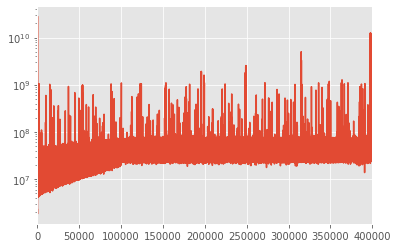

In [5]:
create_timedelta_and_plot(model=model)

In [ ]:
%%time
serial_timesteps = 800000
# EVERYTHING plus 8 cores
past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
print(f'Avg time per total timestep: {(datetime.now()-past).total_seconds()/serial_timesteps/config.n_cpu}')
create_timedelta_and_plot(model=model)

RUN: Training for 4000000 serial timesteps and 4000000 total timesteps...
RUN: Saving files to /tmp/
Done.
Avg time per serial timestep: 0.00092697080325
CPU times: user 1h 2min 6s, sys: 16min 12s, total: 1h 18min 18s
Wall time: 1h 1min 50s


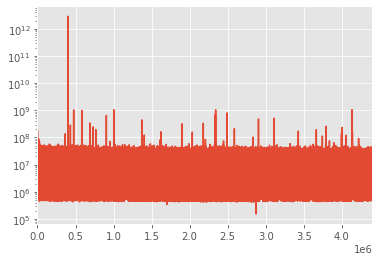

In [5]:
%%time
serial_timesteps = 4000000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

RUN: Training for 400000 serial timesteps and 400000 total timesteps...
Resetting to timesteps: start 17165653, end 17565620.
Resetting current step to start_step (17165653) in train env
RUN: Saving files to /tmp/
Done.
Avg time per serial timestep: 0.005162562585
CPU times: user 33min 41s, sys: 3min 21s, total: 37min 2s
Wall time: 34min 25s


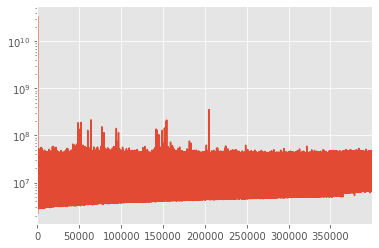

In [4]:
%%time
# Everything except reward
serial_timesteps = 400000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

RUN: Training for 1000000 serial timesteps and 1000000 total timesteps...
Resetting to timesteps: start 17165653, end 17565620.
Resetting current step to start_step (17165653) in train env
Resetting current step to start_step (17165653) in train env
RUN: Saving files to /tmp/
Done.
Avg time per serial timestep: 0.008000388063
CPU times: user 1h 40min 20s, sys: 38min 59s, total: 2h 19min 20s
Wall time: 2h 13min 20s


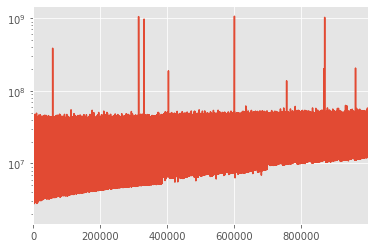

In [4]:
%%time
# Everything except reward
serial_timesteps = 1000000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

In [6]:
test = create_timedelta_and_plot(model=model)

<AxesSubplot:>

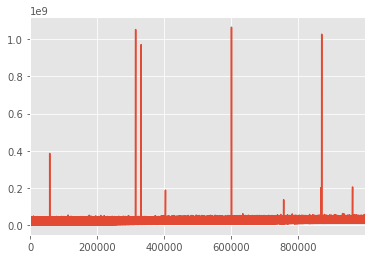

In [10]:
test['timedelta'].plot()

(0.0, 10000000.0)

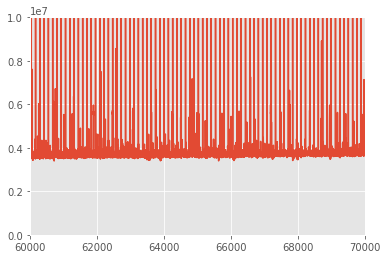

In [12]:
ax=test.loc[60000:70000]['timedelta'].plot()
ax.set_ylim(0, 10000000)

(0.0, 20000000.0)

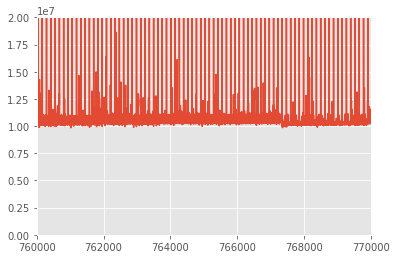

In [14]:
ax=test.loc[760000:770000]['timedelta'].plot()
ax.set_ylim(0, 20000000)

(0.0, 20000000.0)

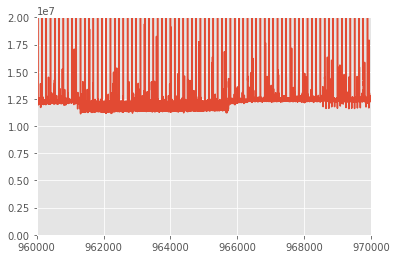

In [15]:
ax=test.loc[960000:970000]['timedelta'].plot()
ax.set_ylim(0, 20000000)

In [4]:
%%time
# Everything except reward AND better account history handling
serial_timesteps = 1000000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

RUN: Training for 1000000 serial timesteps and 1000000 total timesteps...
Resetting to timesteps: start 16565717, end 17565620.
Resetting current step to start_step (16565717) in train env
RUN: Saving files to /tmp/
Done.
Avg time per serial timestep: 0.003265726458
CPU times: user 54min 49s, sys: 6min 9s, total: 1h 59s
Wall time: 54min 26s


,timestamp,timestamp_1,timedelta
0,2020-09-24 12:17:03.504113,2020-09-24 12:17:03.506175,00:00:00.002062
1,2020-09-24 12:17:03.506175,2020-09-24 12:17:03.508119,00:00:00.001944
2,2020-09-24 12:17:03.508119,2020-09-24 12:17:03.510121,00:00:00.002002
3,2020-09-24 12:17:03.510121,2020-09-24 12:17:03.511963,00:00:00.001842
4,2020-09-24 12:17:03.511963,2020-09-24 12:17:03.513851,00:00:00.001888
...,...,...,...
999842,2020-09-24 13:12:32.551547,2020-09-24 13:12:32.554616,00:00:00.003069
999843,2020-09-24 13:12:32.554616,2020-09-24 13:12:32.557491,00:00:00.002875
999844,2020-09-24 13:12:32.557491,2020-09-24 13:12:32.560245,00:00:00.002754
999845,2020-09-24 13:12:32.560245,2020-09-24 13:12:32.563132,00:00:00.002887


In [5]:
test = create_timedelta_and_plot(model=model)

<AxesSubplot:>

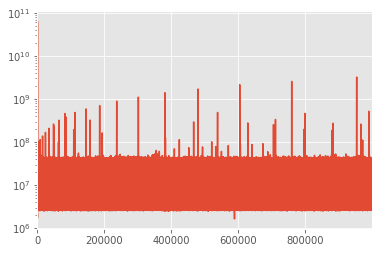

In [7]:
test['timedelta'].plot(logy=True)

RUN: Training for 2000000 serial timesteps and 2000000 total timesteps...
Resetting to timesteps: start 15565653, end 17565620.
Resetting current step to start_step (15565653) in train env
RUN: Saving files to /tmp/
Done.
Avg time per serial timestep: 0.003282865915
CPU times: user 1h 52min 49s, sys: 11min 35s, total: 2h 4min 25s
Wall time: 1h 49min 27s


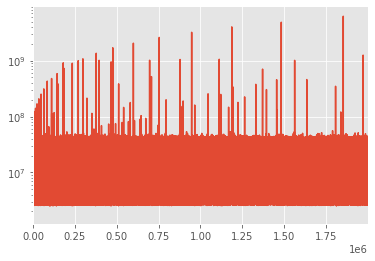

In [5]:
%%time
# Everything except reward AND better account history handling
serial_timesteps = 2000000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

RUN: Training for 1000000 serial timesteps and 1000000 total timesteps...
Resetting to timesteps: start 15565653, end 17565620.
RUN: Saving files to /tmp/
Done.
Avg time per serial timestep: 0.013946390545
CPU times: user 3h 53min 1s, sys: 5min 34s, total: 3h 58min 35s
Wall time: 3h 52min 27s


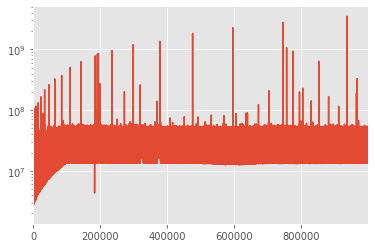

In [4]:
%%time
# Everything INCLUDING reward
serial_timesteps = 1000000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

In [5]:
%%time
# Everything INCLUDING reward
serial_timesteps = 2000000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

RUN: Training for 2000000 serial timesteps and 2000000 total timesteps...
Resetting to timesteps: start 15565653, end 17565620.


KeyboardInterrupt: 

RUN: Training for 30000 serial timesteps and 30000 total timesteps...
Resetting to timesteps: start 1940787, end 1980690.
RUN: Saving files to /tmp/
Done.
Avg time per serial timestep: 0.005629698033333333
CPU times: user 2min 50s, sys: 9.4 s, total: 3min
Wall time: 2min 48s


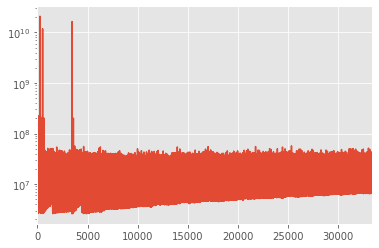

In [10]:
%%time
serial_timesteps = 30000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

RUN: Training for 100000 serial timesteps and 100000 total timesteps...
Resetting to timesteps: start 1940787, end 1980690.
Resetting current step to start_step (1940787) in train env
Resetting current step to start_step (1940787) in train env
RUN: Saving files to /tmp/
Done.
Avg time per serial timestep: 0.010097169559999999
CPU times: user 16min 57s, sys: 32.6 s, total: 17min 30s
Wall time: 16min 50s


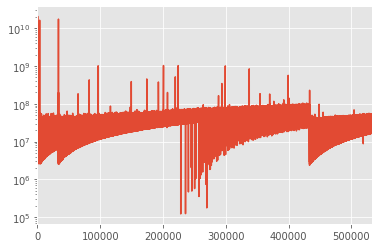

In [13]:
%%time
serial_timesteps = 100000

past = datetime.now()
model = run.train(env=env, serial_timesteps=serial_timesteps, logging=False)
print(f'Avg time per serial timestep: {(datetime.now()-past).total_seconds()/serial_timesteps}')
create_timedelta_and_plot(model=model)

In [15]:
test = create_timedelta_and_plot(model=model)

(0.0, 200000000.0)

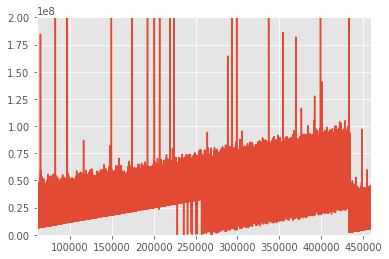

In [24]:
ax=test.loc[60000:460000]['timedelta'].plot()
ax.set_ylim(0, 200000000)

(0.0, 100000000.0)

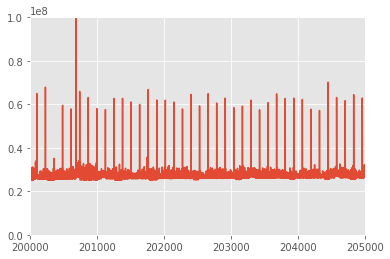

In [28]:
ax=test.loc[200000:205000]['timedelta'].plot()
ax.set_ylim(0, 100000000)

RUN: Loading files from /tmp/
RUN: Model connected with env
RUN: Predicting for 9989 timesteps
Resetting to timesteps: start 17565630, end 17575620.
Rendering TradingChartStatic for index steps 17565630 through 17575619
Not rendering trades since they are too many to distinguish in plot (3223)


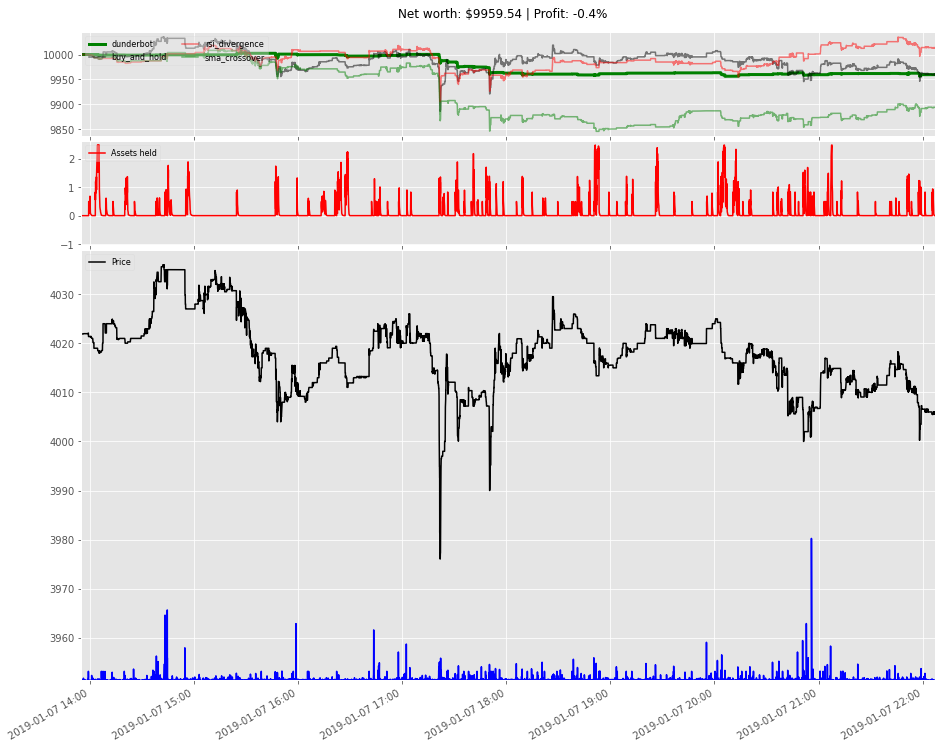

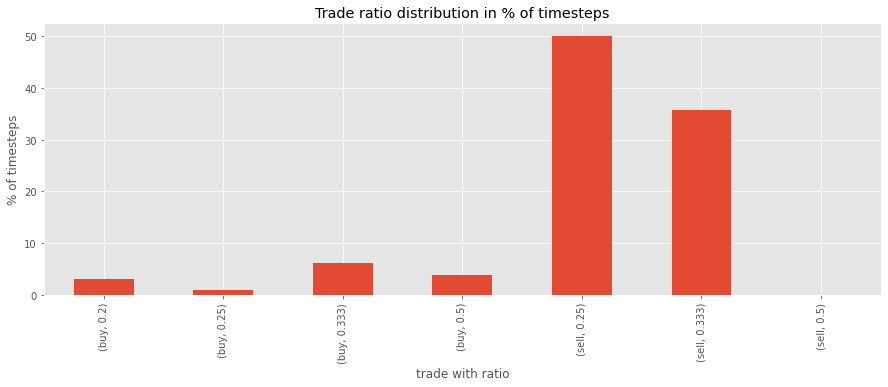

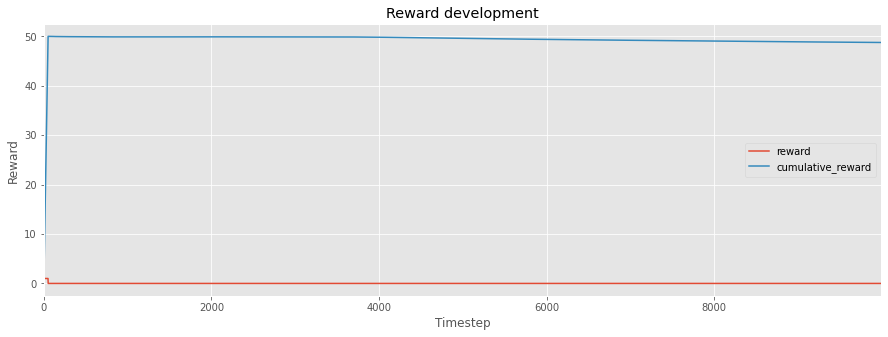

CPU times: user 56.6 s, sys: 184 ms, total: 56.7 s
Wall time: 1min 2s


In [19]:
%%time
run.predict(df=df, rendermode='human')

In [6]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 18,
 'net_worths': [10000.0,
  10000.0,
  10000.0,
  10001.7,
  9993.31,
  9845.08,
  9818.83,
  9857.64,
  9811.18,
  9826.9,
  9849.13,
  9841.65,
  9846.6,
  9906.72,
  9857.82,
  9825.55,
  9844.28,
  9835.73,
  9843.79,
  9853.91,
  9847.28,
  9858.84,
  9884.08,
  9846.62,
  9846.11,
  9859.04,
  9865.74,
  9849.82,
  9871.96,
  9886.04,
  9852.41,
  9828.36,
  9781.67,
  9796.26,
  9789.61,
  9787.16,
  9798.66,
  9821.71,
  9819.04,
  9825.21,
  9813.02,
  9817.28,
  9809.9,
  9810.35,
  9815.73,
  9852.16,
  9844.47,
  9845.15,
  9833.28,
  9836.58,
  9863.32,
  9843.26,
  9846.9,
  9838.6,
  9843.73,
  9840.44,
  9971.54,
  9981.18,
  9980.54,
  9981.68,
  9980.22,
  9984.06,
  10005.04,
  9992.58,
  9998.53,
  10012.4,
  10006.93,
  9995.75,
  9951.78,
  9922.8,
  9824.37,
  9840.96,
  9803.94,
  9764.1,
  9780.03,
  9798.29,
  9787.19,
  9793.24,
  9805.33,
  9789.97,
  9796.14,
  9795.5,
  9814.97,
  9812.16,
  9803.83,
  9817.89,
  9804.12,
  9807.79,
  9

In [8]:
x.keys()

dict_keys(['current_step', 'net_worths', 'trades', 'account_history', 'rewards'])